<a id='home'></a>
### Contents

[Imports](#Imports)

[Dataloading](#Dataloading)

[DrawingGraph](#DrawingGraph)

<a id='Imports'></a>
### Imports
[back to contents](#home)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
from os.path import join as p_join
import sys
from collections import Counter
from datetime import datetime
from typing import List, Tuple, Dict, Set, Any, Optional, Callable
from pathlib import Path
sys.path.insert(0, str(Path(os.getcwd()).parent))
import requests
import json
import pickle
from tqdm import tqdm
try:
    from fabulous import color as fb_color
    color_print = lambda x, color='green': print(getattr(fb_color, color)(x)) if 'fb_color' in globals() else print(x)
except Exception as e:
    color_print = lambda x, color='green': print(x)

from bs4 import BeautifulSoup
from sqlalchemy import create_engine
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import networkx as nx
import ipycytoscape
from ipycytoscape import CytoscapeWidget

In [4]:
pd.set_option('display.max_columns', 200)

In [5]:
matplotlib.rcParams['figure.figsize'] = (7, 7)
sns.set_style('whitegrid')

In [6]:
# from src.common_utils import get_container_ipaddr
# from src.minio_utils import initialize_minio_client, load_json_from_minio
from src.db_utils import get_pg_engine
from src.common_utils import (
    prepare_date,
    clip_categories,
    choose_fighter_stats,
    get_ego_graph,
)

<a id='Dataloading'></a>
### Dataloading
[back to contents](#home)

In [7]:
eng = get_pg_engine()

df = pd.read_sql('select * from raw_data.all_fights_info', eng)
print(f'df: {df.shape[0]:,} x {df.shape[1]:,}')
df.head(3)

df: 7,230 x 165


,names__1,names__2,fight_name,method,round,time,timeformat,referee,date,location,event_name,event_uri,fight_uri,winloose_fighter1,winloose_fighter2,per_round_stats__round1__fighter__1,per_round_stats__round1__fighter__2,per_round_stats__round1__kd__1,per_round_stats__round1__kd__2,per_round_stats__round1__sig_str__1,per_round_stats__round1__sig_str__2,per_round_stats__round1__sig_str_perc__1,per_round_stats__round1__sig_str_perc__2,per_round_stats__round1__totalstr__1,per_round_stats__round1__totalstr__2,per_round_stats__round1__td_perc__1,per_round_stats__round1__td_perc__2,per_round_stats__round1__sub_att__1,per_round_stats__round1__sub_att__2,per_round_stats__round1__rev__1,per_round_stats__round1__rev__2,per_round_stats__round1__ctrl__1,per_round_stats__round1__ctrl__2,per_round_stats__round1__head__1,per_round_stats__round1__head__2,per_round_stats__round1__body__1,per_round_stats__round1__body__2,per_round_stats__round1__leg__1,per_round_stats__round1__leg__2,per_round_stats__round1__distance__1,per_round_stats__round1__distance__2,per_round_stats__round1__clinch__1,per_round_stats__round1__clinch__2,per_round_stats__round1__ground__1,per_round_stats__round1__ground__2,per_round_stats__round2__fighter__1,per_round_stats__round2__fighter__2,per_round_stats__round2__kd__1,per_round_stats__round2__kd__2,per_round_stats__round2__sig_str__1,per_round_stats__round2__sig_str__2,per_round_stats__round2__sig_str_perc__1,per_round_stats__round2__sig_str_perc__2,per_round_stats__round2__totalstr__1,per_round_stats__round2__totalstr__2,per_round_stats__round2__td_perc__1,per_round_stats__round2__td_perc__2,per_round_stats__round2__sub_att__1,per_round_stats__round2__sub_att__2,per_round_stats__round2__rev__1,per_round_stats__round2__rev__2,per_round_stats__round2__ctrl__1,per_round_stats__round2__ctrl__2,per_round_stats__round2__head__1,per_round_stats__round2__head__2,per_round_stats__round2__body__1,per_round_stats__round2__body__2,per_round_stats__round2__leg__1,per_round_stats__round2__leg__2,per_round_stats__round2__distance__1,per_round_stats__round2__distance__2,per_round_stats__round2__clinch__1,per_round_stats__round2__clinch__2,per_round_stats__round2__ground__1,per_round_stats__round2__ground__2,per_round_stats__round3__fighter__1,per_round_stats__round3__fighter__2,per_round_stats__round3__kd__1,per_round_stats__round3__kd__2,per_round_stats__round3__sig_str__1,per_round_stats__round3__sig_str__2,per_round_stats__round3__sig_str_perc__1,per_round_stats__round3__sig_str_perc__2,per_round_stats__round3__totalstr__1,per_round_stats__round3__totalstr__2,per_round_stats__round3__td_perc__1,per_round_stats__round3__td_perc__2,per_round_stats__round3__sub_att__1,per_round_stats__round3__sub_att__2,per_round_stats__round3__rev__1,per_round_stats__round3__rev__2,per_round_stats__round3__ctrl__1,per_round_stats__round3__ctrl__2,per_round_stats__round3__head__1,per_round_stats__round3__head__2,per_round_stats__round3__body__1,per_round_stats__round3__body__2,per_round_stats__round3__leg__1,per_round_stats__round3__leg__2,per_round_stats__round3__distance__1,per_round_stats__round3__distance__2,per_round_stats__round3__clinch__1,per_round_stats__round3__clinch__2,per_round_stats__round3__ground__1,per_round_stats__round3__ground__2,per_round_stats__round4__fighter__1,per_round_stats__round4__fighter__2,per_round_stats__round4__kd__1,per_round_stats__round4__kd__2,per_round_stats__round4__sig_str__1,per_round_stats__round4__sig_str__2,per_round_stats__round4__sig_str_perc__1,per_round_stats__round4__sig_str_perc__2,per_round_stats__round4__totalstr__1,per_round_stats__round4__totalstr__2,per_round_stats__round4__td_perc__1,per_round_stats__round4__td_perc__2,per_round_stats__round4__sub_att__1,per_round_stats__round4__sub_att__2,per_round_stats__round4__rev__1,per_round_stats__round4__rev__2,per_round_stats__round4__ctrl__1,per_round_stats__round4__ctrl__2,per_round_stats__round4__head__1,per_round_stats__round4__head__2,per_round_st

In [8]:
df['date_processed'] = prepare_date(date_col=df['date'])
df['date_year_month'] = df['date_processed'].dt.to_period('M')

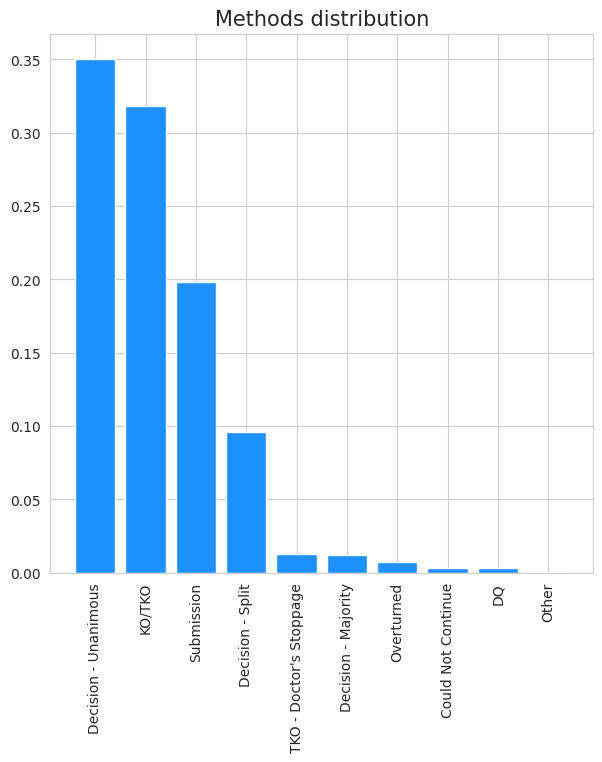

In [9]:
tmp = df['method'].value_counts(1).to_dict()
plt.title('Methods distribution', fontsize=15);
plt.bar(list(tmp.keys()), list(tmp.values()), color='dodgerblue');
plt.tick_params(axis='x', rotation=90);

In [11]:
from src.common_utils import clip_categories

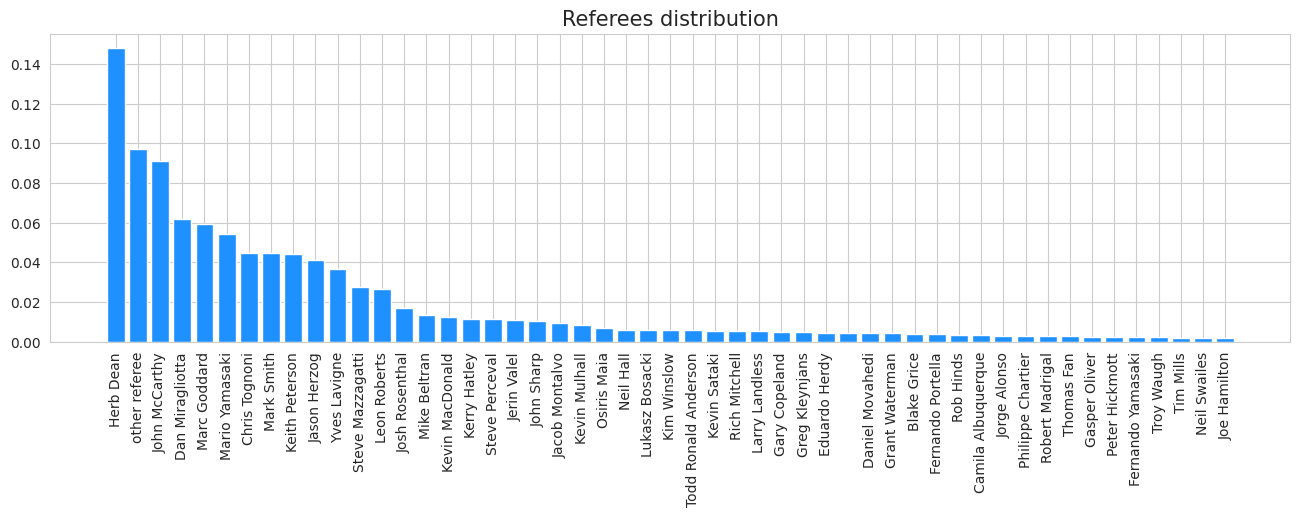

In [12]:
tmp = clip_categories(
    series=df['referee'],
    leave_top_n_categories=50,
    other_category_name='other referee'
)
tmp = tmp.value_counts(1).to_dict()
plt.figure(figsize=(16, 4))
plt.title('Referees distribution', fontsize=15);
plt.bar(list(tmp.keys()), list(tmp.values()), color='dodgerblue');
plt.tick_params(axis='x', rotation=90);

In [13]:
d = datetime.date(df['date_processed'][0])
d
# datetime.date(d.year, d.month // 3 + 1, 1)

datetime.date(2023, 2, 25)

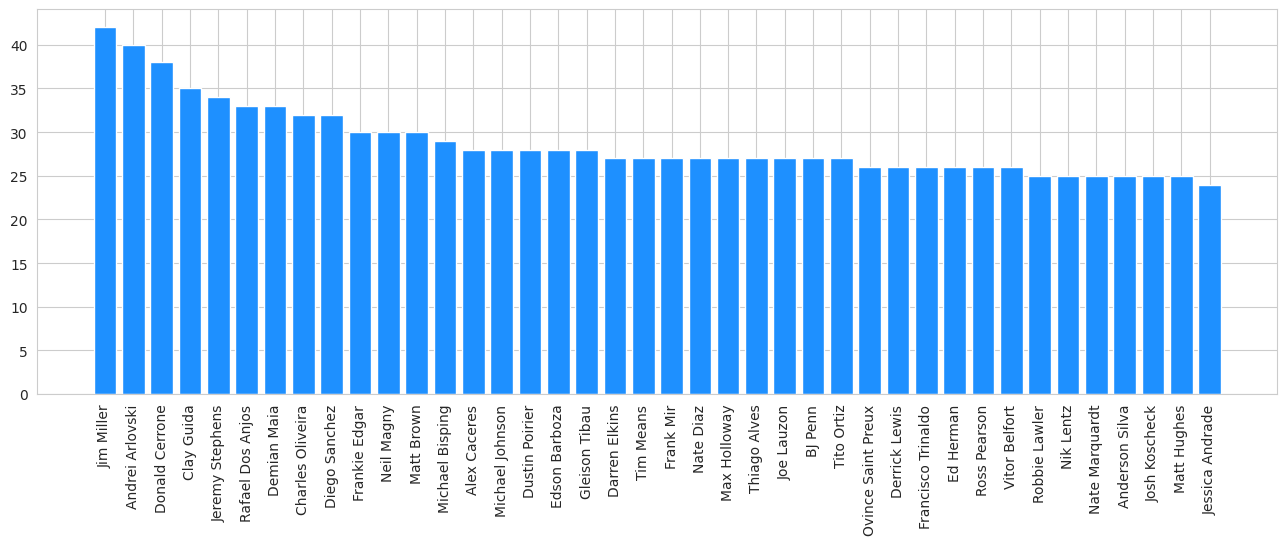

In [14]:
cnt_dict = dict(Counter(df['names__1'].tolist() + df['names__2'].tolist()))
top_k = 40
names, cnts = [], []
for name, cnt in sorted(cnt_dict.items(), key=lambda x: x[1], reverse=True):
    names.append(name)
    cnts.append(cnt)

plt.figure(figsize=(16, 5))
plt.title('Number of fights per fighter', fontsize=15);
plt.title(f'')
plt.bar(names[:top_k], cnts[:top_k], color='dodgerblue')
plt.tick_params(axis='x', rotation=90)

In [15]:
# Number of fights between fighters
df[['names__1', 'names__2']].value_counts()

names__1             names__2         
Deiveson Figueiredo  Brandon Moreno       3
Dustin Poirier       Conor McGregor       3
Tito Ortiz           Ken Shamrock         3
Lyoto Machida        Mauricio Rua         2
Edson Barboza        Paul Felder          2
                                         ..
Fredson Paixao       Pablo Garza          1
Frankie Saenz        Sirwan Kakai         1
                     Merab Dvalishvili    1
                     Jonathan Martinez    1
Zubaira Tukhugov     Phillipe Nover       1
Name: count, Length: 7124, dtype: int64

In [16]:
winloose_dict = {}
uniq_decisions = set(['W', 'L', 'D', 'NC'])
for name1, name2, decision1, decision2 in df[
        ['names__1', 'names__2', 'winloose_fighter1', 'winloose_fighter2']
    ].itertuples(index=False):

    if decision1 not in uniq_decisions or decision2 not in uniq_decisions:
        print(f"WARNING! Strange decision decision1={decision1} decision2={decision2}")
    
    if name1 not in winloose_dict:
        winloose_dict[name1] = {'W': 0, 'L': 0, 'D': 0, 'NC': 0}
    if name2 not in winloose_dict:
        winloose_dict[name2] = {'W': 0, 'L': 0, 'D': 0, 'NC': 0}

    winloose_dict[name1][decision1] += 1
    winloose_dict[name2][decision2] += 1

In [17]:
record_df = pd.DataFrame(winloose_dict).T.reset_index().rename(columns={'index': 'fighter'})
record_df['wins_minus_losses'] = record_df['W'] - record_df['L']
record_df.sort_values(by=['wins_minus_losses', 'W', 'L'], ascending=[False, False, True])

,fighter,W,L,D,NC,wins_minus_losses
878,Jon Jones,21,1,0,1,20
1133,Georges St-Pierre,20,2,0,0,18
247,Dustin Poirier,21,6,0,1,15
473,Amanda Nunes,16,2,0,0,14
305,Charles Oliveira,22,9,0,1,13
...,...,...,...,...,...,...
1382,Naoyuki Kotani,0,5,0,0,-5
1524,Pat Healy,0,5,0,1,-5
1711,John Alessio,0,5,0,0,-5
1097,Joshua Burkman,6,12,0,1,-6


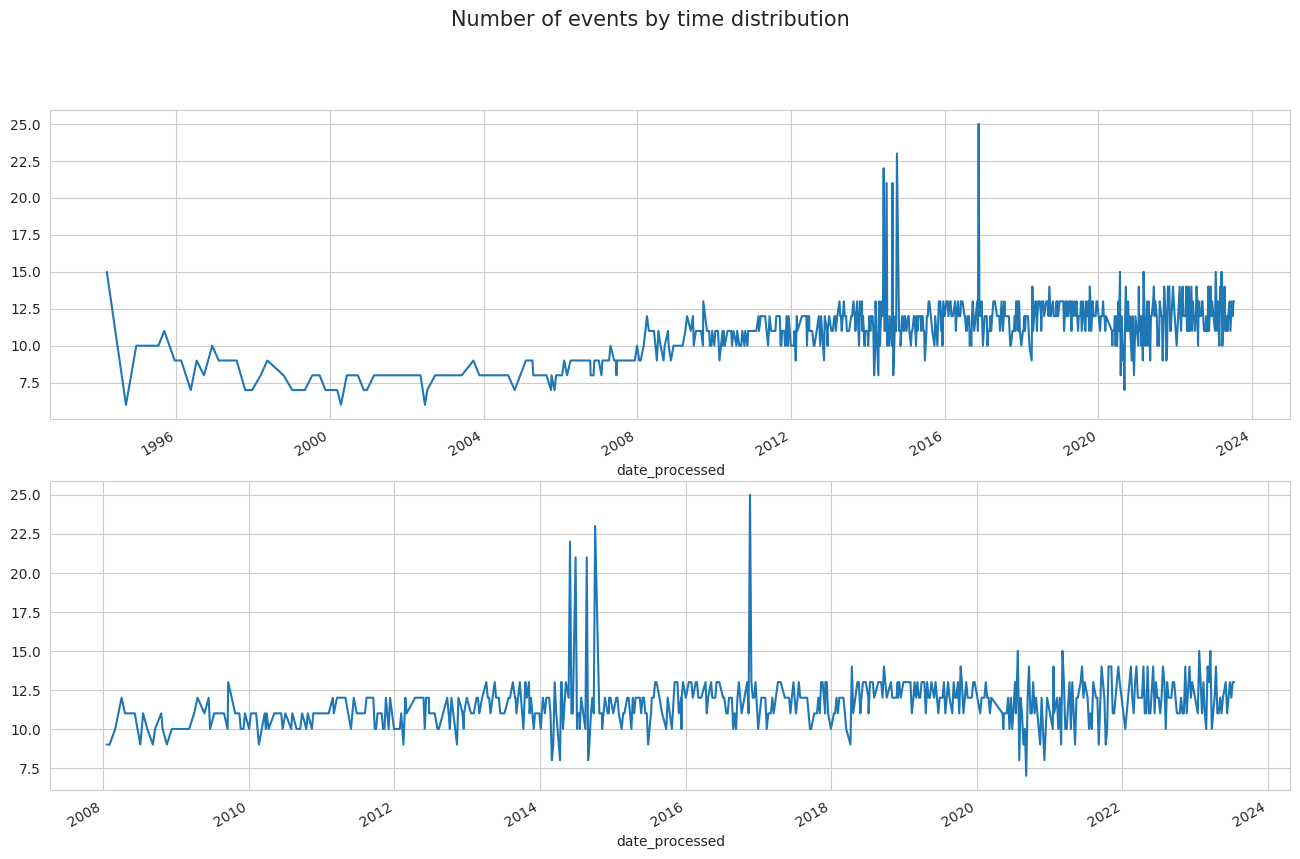

In [18]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 10))
fig.suptitle("Number of events by time distribution", fontsize=15);
df['date_processed'].value_counts().sort_index().plot(kind='line', ax=ax[0])
df['date_processed'][(df['date_processed'] >= datetime(2008, 1, 1))].value_counts().sort_index().plot(kind='line', ax=ax[1]);

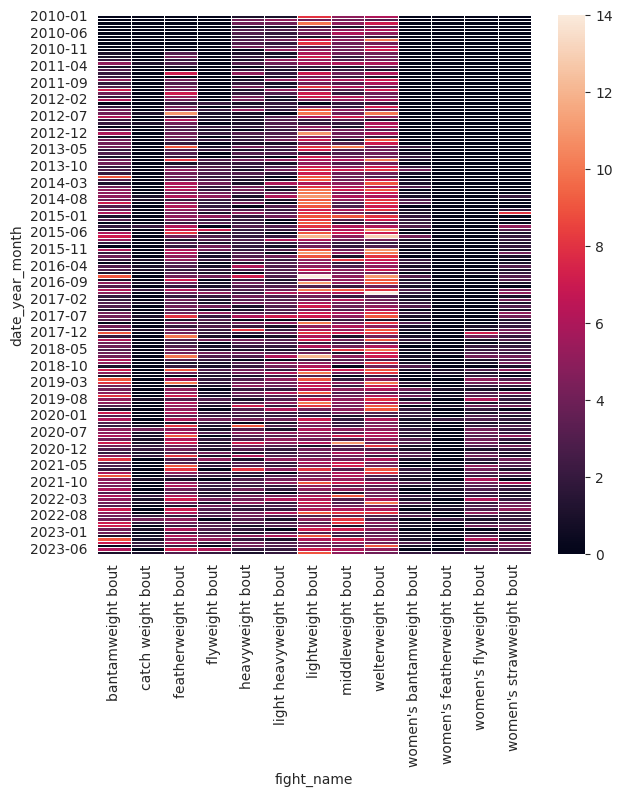

In [19]:
tmp = (
    df.loc[
        (
            df['fight_name'].apply(
                lambda x: (not x.startswith('ufc')) and (not x.startswith('ultimate')) and (not x.startswith('tuf'))
            )
        ) &
        (df['date_processed'] >= datetime(2010, 1, 1))
    ]
    .groupby('date_year_month')
    ['fight_name']
    .value_counts()
    .reset_index()
)

weights_by_month_df = pd.pivot_table(
    data=tmp,
    values='count',
    index='date_year_month',
    columns='fight_name',
    aggfunc=sum,
    fill_value=0,
)
# weights_by_month_df = weights_by_month_df/weights_by_month_df.sum(axis=1)
sns.heatmap(weights_by_month_df, lw=0.5, annot=False);

<a id='DrawingGraph'></a>
### DrawingGraph
[back to contents](#home)

In [10]:
# from ydata_profiling import ProfileReport
# report = ProfileReport(df=df)
# report.to_file(p_join(str(Path(os.getcwd()).parent), 'reports', 'raw_data_report.html'))

In [10]:
# fighter = 'Khabib Nurmagomedov'
fighter = 'Conor McGregor'
# fighter = 'Dustin Poirier'
one_fighter_stats_df = choose_fighter_stats(
    raw_fights_df=df, 
    fighter_name=fighter
)
print(f"one_fighter_stats_df: {one_fighter_stats_df.shape[0]:,}")
one_fighter_stats_df.head(3)

one_fighter_stats_df: 14


,names__1,names__2,fight_name,method,round,time,timeformat,referee,date,location,event_name,event_uri,fight_uri,winloose_fighter1,winloose_fighter2,per_round_stats__round1__fighter__1,per_round_stats__round1__fighter__2,per_round_stats__round1__kd__1,per_round_stats__round1__kd__2,per_round_stats__round1__sig_str__1,per_round_stats__round1__sig_str__2,per_round_stats__round1__sig_str_perc__1,per_round_stats__round1__sig_str_perc__2,per_round_stats__round1__totalstr__1,per_round_stats__round1__totalstr__2,per_round_stats__round1__td_perc__1,per_round_stats__round1__td_perc__2,per_round_stats__round1__sub_att__1,per_round_stats__round1__sub_att__2,per_round_stats__round1__rev__1,per_round_stats__round1__rev__2,per_round_stats__round1__ctrl__1,per_round_stats__round1__ctrl__2,per_round_stats__round1__head__1,per_round_stats__round1__head__2,per_round_stats__round1__body__1,per_round_stats__round1__body__2,per_round_stats__round1__leg__1,per_round_stats__round1__leg__2,per_round_stats__round1__distance__1,per_round_stats__round1__distance__2,per_round_stats__round1__clinch__1,per_round_stats__round1__clinch__2,per_round_stats__round1__ground__1,per_round_stats__round1__ground__2,per_round_stats__round2__fighter__1,per_round_stats__round2__fighter__2,per_round_stats__round2__kd__1,per_round_stats__round2__kd__2,per_round_stats__round2__sig_str__1,per_round_stats__round2__sig_str__2,per_round_stats__round2__sig_str_perc__1,per_round_stats__round2__sig_str_perc__2,per_round_stats__round2__totalstr__1,per_round_stats__round2__totalstr__2,per_round_stats__round2__td_perc__1,per_round_stats__round2__td_perc__2,per_round_stats__round2__sub_att__1,per_round_stats__round2__sub_att__2,per_round_stats__round2__rev__1,per_round_stats__round2__rev__2,per_round_stats__round2__ctrl__1,per_round_stats__round2__ctrl__2,per_round_stats__round2__head__1,per_round_stats__round2__head__2,per_round_stats__round2__body__1,per_round_stats__round2__body__2,per_round_stats__round2__leg__1,per_round_stats__round2__leg__2,per_round_stats__round2__distance__1,per_round_stats__round2__distance__2,per_round_stats__round2__clinch__1,per_round_stats__round2__clinch__2,per_round_stats__round2__ground__1,per_round_stats__round2__ground__2,per_round_stats__round3__fighter__1,per_round_stats__round3__fighter__2,per_round_stats__round3__kd__1,per_round_stats__round3__kd__2,per_round_stats__round3__sig_str__1,per_round_stats__round3__sig_str__2,per_round_stats__round3__sig_str_perc__1,per_round_stats__round3__sig_str_perc__2,per_round_stats__round3__totalstr__1,per_round_stats__round3__totalstr__2,per_round_stats__round3__td_perc__1,per_round_stats__round3__td_perc__2,per_round_stats__round3__sub_att__1,per_round_stats__round3__sub_att__2,per_round_stats__round3__rev__1,per_round_stats__round3__rev__2,per_round_stats__round3__ctrl__1,per_round_stats__round3__ctrl__2,per_round_stats__round3__head__1,per_round_stats__round3__head__2,per_round_stats__round3__body__1,per_round_stats__round3__body__2,per_round_stats__round3__leg__1,per_round_stats__round3__leg__2,per_round_stats__round3__distance__1,per_round_stats__round3__distance__2,per_round_stats__round3__clinch__1,per_round_stats__round3__clinch__2,per_round_stats__round3__ground__1,per_round_stats__round3__ground__2,per_round_stats__round4__fighter__1,per_round_stats__round4__fighter__2,per_round_stats__round4__kd__1,per_round_stats__round4__kd__2,per_round_stats__round4__sig_str__1,per_round_stats__round4__sig_str__2,per_round_stats__round4__sig_str_perc__1,per_round_stats__round4__sig_str_perc__2,per_round_stats__round4__totalstr__1,per_round_stats__round4__totalstr__2,per_round_stats__round4__td_perc__1,per_round_stats__round4__td_perc__2,per_round_stats__round4__sub_att__1,per_round_stats__round4__sub_att__2,per_round_stats__round4__rev__1,per_round_stats__round4__rev__2,per_round_stats__round4__ctrl__1,per_round_stats__round4__ctrl__2,per_round_stats__round4__head__1,per_round_stats__round4__head__2,per_round_st

In [11]:
from src.common_utils import get_ego_graph
fighter = 'Khabib Nurmagomedov'
# fighter = 'Conor McGregor'
# fighter = 'Dustin Poirier'

ego_graph_df = get_ego_graph(
    raw_fights_df=df,
    fighter_name=fighter
)
ego_graph_df.head(3)

,names__1,names__2,fight_name,method,round,time,timeformat,referee,date,location,event_name,event_uri,fight_uri,winloose_fighter1,winloose_fighter2,per_round_stats__round1__fighter__1,per_round_stats__round1__fighter__2,per_round_stats__round1__kd__1,per_round_stats__round1__kd__2,per_round_stats__round1__sig_str__1,per_round_stats__round1__sig_str__2,per_round_stats__round1__sig_str_perc__1,per_round_stats__round1__sig_str_perc__2,per_round_stats__round1__totalstr__1,per_round_stats__round1__totalstr__2,per_round_stats__round1__td_perc__1,per_round_stats__round1__td_perc__2,per_round_stats__round1__sub_att__1,per_round_stats__round1__sub_att__2,per_round_stats__round1__rev__1,per_round_stats__round1__rev__2,per_round_stats__round1__ctrl__1,per_round_stats__round1__ctrl__2,per_round_stats__round1__head__1,per_round_stats__round1__head__2,per_round_stats__round1__body__1,per_round_stats__round1__body__2,per_round_stats__round1__leg__1,per_round_stats__round1__leg__2,per_round_stats__round1__distance__1,per_round_stats__round1__distance__2,per_round_stats__round1__clinch__1,per_round_stats__round1__clinch__2,per_round_stats__round1__ground__1,per_round_stats__round1__ground__2,per_round_stats__round2__fighter__1,per_round_stats__round2__fighter__2,per_round_stats__round2__kd__1,per_round_stats__round2__kd__2,per_round_stats__round2__sig_str__1,per_round_stats__round2__sig_str__2,per_round_stats__round2__sig_str_perc__1,per_round_stats__round2__sig_str_perc__2,per_round_stats__round2__totalstr__1,per_round_stats__round2__totalstr__2,per_round_stats__round2__td_perc__1,per_round_stats__round2__td_perc__2,per_round_stats__round2__sub_att__1,per_round_stats__round2__sub_att__2,per_round_stats__round2__rev__1,per_round_stats__round2__rev__2,per_round_stats__round2__ctrl__1,per_round_stats__round2__ctrl__2,per_round_stats__round2__head__1,per_round_stats__round2__head__2,per_round_stats__round2__body__1,per_round_stats__round2__body__2,per_round_stats__round2__leg__1,per_round_stats__round2__leg__2,per_round_stats__round2__distance__1,per_round_stats__round2__distance__2,per_round_stats__round2__clinch__1,per_round_stats__round2__clinch__2,per_round_stats__round2__ground__1,per_round_stats__round2__ground__2,per_round_stats__round3__fighter__1,per_round_stats__round3__fighter__2,per_round_stats__round3__kd__1,per_round_stats__round3__kd__2,per_round_stats__round3__sig_str__1,per_round_stats__round3__sig_str__2,per_round_stats__round3__sig_str_perc__1,per_round_stats__round3__sig_str_perc__2,per_round_stats__round3__totalstr__1,per_round_stats__round3__totalstr__2,per_round_stats__round3__td_perc__1,per_round_stats__round3__td_perc__2,per_round_stats__round3__sub_att__1,per_round_stats__round3__sub_att__2,per_round_stats__round3__rev__1,per_round_stats__round3__rev__2,per_round_stats__round3__ctrl__1,per_round_stats__round3__ctrl__2,per_round_stats__round3__head__1,per_round_stats__round3__head__2,per_round_stats__round3__body__1,per_round_stats__round3__body__2,per_round_stats__round3__leg__1,per_round_stats__round3__leg__2,per_round_stats__round3__distance__1,per_round_stats__round3__distance__2,per_round_stats__round3__clinch__1,per_round_stats__round3__clinch__2,per_round_stats__round3__ground__1,per_round_stats__round3__ground__2,per_round_stats__round4__fighter__1,per_round_stats__round4__fighter__2,per_round_stats__round4__kd__1,per_round_stats__round4__kd__2,per_round_stats__round4__sig_str__1,per_round_stats__round4__sig_str__2,per_round_stats__round4__sig_str_perc__1,per_round_stats__round4__sig_str_perc__2,per_round_stats__round4__totalstr__1,per_round_stats__round4__totalstr__2,per_round_stats__round4__td_perc__1,per_round_stats__round4__td_perc__2,per_round_stats__round4__sub_att__1,per_round_stats__round4__sub_att__2,per_round_stats__round4__rev__1,per_round_stats__round4__rev__2,per_round_stats__round4__ctrl__1,per_round_stats__round4__ctrl__2,per_round_stats__round4__head__1,per_round_stats__round4__head__2,per_round_st

In [12]:
adjacency_dict = {}
for name1, name2, wl1, wl2 in (
    ego_graph_df[
        ['names__1', 'names__2', 'winloose_fighter1', 'winloose_fighter2']
    ].itertuples(index=False)
):
    
    name1 = name1.replace(' ', '')
    name2 = name2.replace(' ', '')
    if wl1 == wl2 == 'NC':
        continue

    if wl1 == 'W':
        assert wl2 == 'L', 'wl2 should be `L` in this case!'
        if name1 not in adjacency_dict:
            adjacency_dict[name1] = []
        if name2 not in adjacency_dict[name1]:
            adjacency_dict[name1].append(name2)
    elif wl2 == 'W':
        assert wl1 == 'L', 'wl1 should be `L` in this case!'
        if name2 not in adjacency_dict:
            adjacency_dict[name2] = []
        if name1 not in adjacency_dict[name2]:
            adjacency_dict[name2].append(name1)
adjacency_dict

{'KhabibNurmagomedov': ['JustinGaethje',
  'DustinPoirier',
  'ConorMcGregor',
  'AlIaquinta',
  'EdsonBarboza',
  'MichaelJohnson',
  'DarrellHorcher',
  'RafaelDosAnjos',
  'PatHealy',
  'AbelTrujillo',
  'ThiagoTavares',
  'GleisonTibau',
  'KamalShalorus'],
 'RafaelDosAnjos': ['KamalShalorus',
  'BryanBarberena',
  'RenatoMoicano',
  'PaulFelder',
  'KevinLee',
  'RobbieLawler',
  'NeilMagny',
  'TarecSaffiedine',
  'DonaldCerrone',
  'AnthonyPettis',
  'NateDiaz',
  'BensonHenderson',
  'JasonHigh',
  'EvanDunham',
  'MarkBocek',
  'AnthonyNjokuani',
  'GeorgeSotiropoulos',
  'TerryEtim',
  'KyleBradley',
  'RobEmerson'],
 'JimMiller': ['KamalShalorus', 'GleisonTibau'],
 'BryceMitchell': ['EdsonBarboza'],
 'GigaChikadze': ['EdsonBarboza'],
 'EdsonBarboza': ['ShaneBurgos',
  'MakwanAmirkhani',
  'DanHooker',
  'BeneilDariush',
  'GilbertMelendez',
  'AnthonyPettis',
  'PaulFelder',
  'BobbyGreen',
  'EvanDunham',
  'DannyCastillo',
  'RafaelloOliveira',
  'LucasMartins',
  'TerryEt

In [33]:
json.dump(
    adjacency_dict,
    open('/home/aiandrejcev/tmp/tmp.json', mode='w', encoding='utf-8'),
    ensure_ascii=False,
    indent=2
)

In [13]:
ego_graph_df[['names__1', 'names__2']].to_csv('/home/aiandrejcev/tmp/tmp.csv', index=False)

In [ ]:
G = nx.DiGraph()
G.add_edges_from(ego_graph_df[['names__1', 'names__2']].itertuples(index=False))
G

In [ ]:
nx.draw_kamada_kawai(
    G=G,
    edge_color='black',  
    node_size = 15, 
    width  = 0.1, 
    labels = {name: name for i, name in enumerate(G.nodes, start=0)}, 
    font_family  = 'Verdana', 
    font_size=8
)

In [16]:
graph_dict = {
    "nodes": [],
    "edges": []
}
fighters_set = set([])
for fighter1, fighter2 in ego_graph_df[['names__1', 'names__2']].itertuples(index=False):
    if fighter1 not in fighters_set:
        graph_dict['nodes'].append({
            "data": {"id": fighter1, "fighter": fighter1}
        })
        fighters_set.add(fighter1)
    if fighter2 not in fighters_set:
        graph_dict['nodes'].append({
            "data": {"id": fighter2, "fighter": fighter2}
        })
        fighters_set.add(fighter2)
    graph_dict['edges'].append({
            "data": {"source": fighter1, "target": fighter2}
        })
graph_dict

{'nodes': [{'data': {'id': 'Khabib Nurmagomedov',
    'fighter': 'Khabib Nurmagomedov'}},
  {'data': {'id': 'Justin Gaethje', 'fighter': 'Justin Gaethje'}},
  {'data': {'id': 'Dustin Poirier', 'fighter': 'Dustin Poirier'}},
  {'data': {'id': 'Conor McGregor', 'fighter': 'Conor McGregor'}},
  {'data': {'id': 'Al Iaquinta', 'fighter': 'Al Iaquinta'}},
  {'data': {'id': 'Edson Barboza', 'fighter': 'Edson Barboza'}},
  {'data': {'id': 'Michael Johnson', 'fighter': 'Michael Johnson'}},
  {'data': {'id': 'Darrell Horcher', 'fighter': 'Darrell Horcher'}},
  {'data': {'id': 'Rafael Dos Anjos', 'fighter': 'Rafael Dos Anjos'}},
  {'data': {'id': 'Pat Healy', 'fighter': 'Pat Healy'}},
  {'data': {'id': 'Abel Trujillo', 'fighter': 'Abel Trujillo'}},
  {'data': {'id': 'Thiago Tavares', 'fighter': 'Thiago Tavares'}},
  {'data': {'id': 'Gleison Tibau', 'fighter': 'Gleison Tibau'}},
  {'data': {'id': 'Kamal Shalorus', 'fighter': 'Kamal Shalorus'}},
  {'data': {'id': 'Jim Miller', 'fighter': 'Jim Mille

In [18]:
json.dump(
    graph_dict,
    open('/home/aiandrejcev/tmp/graph_dict.json', mode='w', encoding='utf-8'),
    ensure_ascii=False,
    indent=2
)

In [15]:
from yfiles_jupyter_graphs import GraphWidget
w = GraphWidget()
w.nodes = [
    {"id": 0, "properties": {"firstName": "Alpha", "label": "Person A"}},
    {"id": "one", "properties": {"firstName": "Bravo", "label": "Person B"}},
    {"id": 2.0, "properties": {"firstName": "Charlie", "label": "Person C", "has_hat": False}},
    {"id": True, "properties": {"firstName": "Delta", "label": "Person D", "likes_pizza": True}}
]
w.edges = [
    {"id": "zero", "start": 0, "end": "one", "properties": {"since": "1992", "label": "knows"}},
    {"id": 1, "start": "one", "end": True, "properties": {"label": "knows", "since": "1992"}},
    {"id": 2.0, "start": 2.0, "end": True, "properties": {"label": "knows", "since": "1992"}},
    {"id": False, "start": 0, "end": 2.0, "properties": {"label": "knows", "since": 234}}
]
w.directed = True
w.show() 

GraphWidget(layout=Layout(height='500px', width='100%'))

In [105]:
style = [
    {
        "selector": 'core',
        "style": {
            "selection-box-color": '#000',
        }
    },
    {
        'selector': 'node',
        'style': {
            'font-family': 'arial',
            'font-size': '6px',
            "text-valign": "center",
            "text-halign": "center",
            'text-background-color': '#77828',
            "text-border-color": 'red',
            'label': 'data(fighter)',
            'background-color': 'blue'
        }
    },
    {
        'selector': 'edge',
        'style': {
            'curve-style': 'haystack',
            'haystack-radius': '0.5',
            'opacity': '0.4',
            'line-color': '#bbb',
            'width': '2',
            'overlay-padding': '3px'
        }
    }
]

In [106]:
directed = CytoscapeWidget()
directed.graph.add_graph_from_json(graph_dict, directed=True)
directed.set_layout(name='cose', nodeSpacing=40, edgeLengthVal=1000)
directed.set_style(style)
directed

CytoscapeWidget(cytoscape_layout={'name': 'cose', 'nodeSpacing': 40, 'edgeLengthVal': 1000}, cytoscape_style=[…

In [ ]:
G = nx.complete_graph(5)
undirected = CytoscapeWidget()
undirected.graph.add_graph_from_networkx(G)
display(undirected)

In [ ]:
G2 = nx.Graph()
G2.add_node('separate node 1')
G2.add_node('separate node 2')
G2.add_edge('separate node 1', 'separate node 2')
undirected.graph.add_graph_from_networkx(G2)

In [ ]:
G = nx.complete_graph(5)
directed = ipycytoscape.CytoscapeWidget()
directed.graph.add_graph_from_networkx(G, directed=True)
directed


In [ ]:
data = {
    'nodes': [
        { 'data': { 'id': 'desktop', 'name': 'Cytoscape', 'href': 'http://cytoscape.org' } },
        { 'data': { 'id': 'a', 'name': 'Grid', 'href': 'http://cytoscape.org' } },
        { 'data': { 'id': 'b', 'name': 'Cola', 'href': 'http://cytoscape.org' } },
        { 'data': { 'id': 'c', 'name': 'Popper', 'href': 'http://cytoscape.org' } },
        { 'data': { 'id': 'js', 'name': 'Cytoscape.js', 'href': 'http://js.cytoscape.org' } }
    ],
    'edges': [
        {'data': { 'source': 'desktop', 'target': 'js' }},
        {'data': { 'source': 'a', 'target': 'b' }},
        {'data': { 'source': 'a', 'target': 'c' }},
        {'data': { 'source': 'b', 'target': 'c' }},
        {'data': { 'source': 'js', 'target': 'b' }}
    ]
}
cytoscapeobj = CytoscapeWidget()
cytoscapeobj.graph.add_graph_from_json(data, directed=True)
cytoscapeobj.set_style([{
                        'selector': 'node',
                        'css': {
                            'content': 'data(name)',
                            'text-valign': 'center',
                            'color': 'white',
                            'text-outline-width': 2,
                            'text-outline-color': 'black',
                            'background-color': 'blue'
                        }
                        },
                        {
                        'selector': ':selected',
                        'css': {
                            'background-color': 'black',
                            'line-color': 'black',
                            'target-arrow-color': 'black',
                            'source-arrow-color': 'black',
                            'text-outline-color': 'black'
                        }}
                        ])
cytoscapeobj

In [26]:
railnet= '''{
    "nodes": [
        {"data": { "id": "BER" }},
        {"data": { "id": "MUN"}},
        {"data": { "id": "FRA"}},
        {"data": { "id": "HAM"}}
        ],
    "edges": [
        {"data": { "source": "BER", "target": "MUN" }},
        {"data": { "source": "MUN", "target": "FRA" }},
        {"data": { "source": "FRA", "target": "BER" }},
        {"data": { "source": "BER", "target": "HAM" }}
        
    ]
  }'''
print(type(railnet))
railnetJSON = json.loads(railnet)

<class 'str'>


In [28]:
tmp = ipycytoscape.CytoscapeWidget()

In [29]:
tmp.graph.add_graph_from_json(railnetJSON)
tmp

CytoscapeWidget(cytoscape_layout={'name': 'cola'}, cytoscape_style=[{'selector': 'node', 'css': {'background-c…

In [30]:
ipycytoscape_obj2 = ipycytoscape.CytoscapeWidget()
ipycytoscape_obj2.graph.add_graph_from_json(railnetJSON, directed=True) # I am telling I dont want directions
ipycytoscape_obj2

CytoscapeWidget(cytoscape_layout={'name': 'cola'}, cytoscape_style=[{'selector': 'node', 'css': {'background-c…

In [32]:
railnet= '''{
    "nodes": [
        {"data": { "id": "BER", "label":"HBf BER"}},
        {"data": { "id": "MUN", "label":"HBf MUN"}},
        {"data": { "id": "FRA", "label":"HBf FRA"}},
        {"data": { "id": "HAM", "label":"HBf HAM"}}
        ],
    "edges": [
        {"data": { "source": "BER", "target": "MUN" }},
        {"data": { "source": "MUN", "target": "FRA" }},
        {"data": { "source": "FRA", "target": "BER" }},
        {"data": { "source": "BER", "target": "HAM" }}
        
    ]
  }'''

my_style = [
    {'selector': 'node','style': {
        'font-family': 'helvetica',
        'font-size': '20px',
        'label': 'data(label)'}},
    ]

railnetJSON = json.loads(railnet)
ipycytoscape_obj4 = ipycytoscape.CytoscapeWidget()
ipycytoscape_obj4.graph.add_graph_from_json(railnetJSON, directed=False) # I am telling I dont want directions
ipycytoscape_obj4.set_style(my_style)
ipycytoscape_obj4

CytoscapeWidget(cytoscape_layout={'name': 'cola'}, cytoscape_style=[{'selector': 'node', 'style': {'font-famil…

In [33]:
my_style = [
    {'selector': 'node','style': {
        'font-family': 'arial',
        'font-size': '10px',
        'label': 'data(label)',
        'background-color': 'red'}},
    
    {'selector': 'node[id = "BER"]','style': {
        'font-family': 'arial',
        'font-size': '10px',
        'label': 'data(label)',
        'background-color': 'green'}}
    
    ]
ipycytoscape_obj7 = ipycytoscape.CytoscapeWidget()
ipycytoscape_obj7.graph.add_graph_from_json(railnetJSON, directed=False) # I am telling I dont want directions
ipycytoscape_obj7.set_style(my_style)
ipycytoscape_obj7.set_style(my_style)
ipycytoscape_obj7

CytoscapeWidget(cytoscape_layout={'name': 'cola'}, cytoscape_style=[{'selector': 'node', 'style': {'font-famil…

In [34]:
railnet= '''{
    "nodes": [
        {"data": { "id": "BER", "label":"HBf BER"}},
        {"data": { "id": "MUN", "label":"HBf MUN"}},
        {"data": { "id": "FRA", "label":"HBf FRA"}},
        {"data": { "id": "HAM", "label":"HBf HAM"}}
        ],
    "edges": [
        {"data": { "id": "line1", "source": "BER", "target": "MUN","label":"200km/h"}},
        {"data": { "id": "line2", "source": "MUN", "target": "FRA","label":"200km/h"}},
        {"data": { "id": "line3", "source": "FRA", "target": "BER","label":"250km/h" }},
        {"data": { "id": "line4", "source": "BER", "target": "HAM","label":"300km/h" }}
        
    ]
  }'''

my_style = [
    {'selector': 'node','style': {
        'font-family': 'arial',
        'font-size': '10px',
        'label': 'data(label)',
        'background-color': 'red'}},
    
    {'selector': 'node[id = "BER"]','style': {
        'font-family': 'arial',
        'font-size': '10px',
        'label': 'data(label)',
        'background-color': 'green'}},
    
    {'selector': 'edge[id = "line1"]','style': {
        'font-family': 'arial',
        'font-size': '10px',
        'label': 'data(label)',}},
    
    {'selector': 'edge[id = "line2"]','style': {
        'font-family': 'arial',
        'font-size': '10px',
        'label': 'data(label)',}},
    
    {'selector': 'edge[id = "line3"]','style': {
        'font-family': 'arial',
        'font-size': '10px',
        'label': 'data(label)',}},
    
    {'selector': 'edge[id = "line4"]','style': {
        'font-family': 'arial',
        'font-size': '10px',
        'label': 'data(label)',}}
    
    ]
railnetJSON = json.loads(railnet)
ipycytoscape_obj8 = ipycytoscape.CytoscapeWidget()
ipycytoscape_obj8.graph.add_graph_from_json(railnetJSON, directed=True) # We're specifying that the graph should be undirected
ipycytoscape_obj8.set_style(my_style)
ipycytoscape_obj8.set_style(my_style)
ipycytoscape_obj8

CytoscapeWidget(cytoscape_layout={'name': 'cola'}, cytoscape_style=[{'selector': 'node', 'style': {'font-famil…

In [36]:
railnet= '''{
    "nodes": [
        {"data": { "id": "BER", "label":"HBf BER"}, "classes":"east"},
        {"data": { "id": "MUN", "label":"HBf MUN"}, "classes":"west"},
        {"data": { "id": "FRA", "label":"HBf FRA"}, "classes":"west"},
        {"data": { "id": "HAM", "label":"HBf HAM"}, "classes":"west"},
        {"data": { "id": "LEP", "label":"HBf LEP"}, "classes":"east"}
        ],
    "edges": [
        {"data": { "id": "line1", "source": "BER", "target": "MUN","label":"200km/h"}},
        {"data": { "id": "line2", "source": "MUN", "target": "FRA","label":"200km/h"}},
        {"data": { "id": "line3", "source": "FRA", "target": "BER","label":"250km/h" }},
        {"data": { "id": "line4", "source": "BER", "target": "HAM","label":"300km/h" }},
        {"data": { "id": "line5", "source": "BER", "target": "LEP","label":"300km/h" }}
        
    ]
  }'''

my_style = [
    {'selector': 'node','style': {
        'font-family': 'arial',
        'font-size': '10px',
        'label': 'data(label)',}},
    
    {'selector': 'node.east','style': {
        'background-color': 'yellow'}},
    
     {'selector': 'node.west','style': {
        'background-color': 'blue'}},
    
    
    {'selector': 'node[id = "BER"]','style': {
        'font-family': 'arial',
        'font-size': '10px',
        'label': 'data(label)',
        'background-color': 'orange'}},
    
    {'selector': 'edge[id = "line1"]','style': {
        'font-family': 'arial',
        'font-size': '10px',
        'label': 'data(label)'}},
    
    {'selector': 'edge[id = "line2"]','style': {
        'font-family': 'arial',
        'font-size': '10px',
        'label': 'data(label)'}},
    
    {'selector': 'edge[id = "line3"]','style': {
        'font-family': 'arial',
        'font-size': '10px',
        'label': 'data(label)'}},
    
    {'selector': 'edge[id = "line4"]','style': {
        'font-family': 'arial',
        'font-size': '10px',
        'label': 'data(label)'}},
    
    {'selector': 'edge[id = "line5"]','style': {
        'font-family': 'arial',
        'font-size': '10px',
        'label': 'data(label)'}}
    
    ]
railnetJSON = json.loads(railnet)
ipycytoscape_obj9 = ipycytoscape.CytoscapeWidget()
ipycytoscape_obj9.graph.add_graph_from_json(railnetJSON, directed=True) # We're specifying that the graph should be undirected
ipycytoscape_obj9.set_style(my_style)
ipycytoscape_obj9

CytoscapeWidget(cytoscape_layout={'name': 'cola'}, cytoscape_style=[{'selector': 'node', 'style': {'font-famil…